<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Plot-delta-E-vs-log(k_n)" data-toc-modified-id="Plot-delta-E-vs-log(k_n)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot delta E vs log(k_n)</a></span></li><li><span><a href="#Parity-plot" data-toc-modified-id="Parity-plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parity plot</a></span></li><li><span><a href="#Figure-4-&amp;-5:-molecule-61" data-toc-modified-id="Figure-4-&amp;-5:-molecule-61-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 4 &amp; 5: molecule 61</a></span></li></ul></div>

# Imports

In [9]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Plot delta E vs log(k_n)

In [12]:
def plot_dE_vs_logk(mechanism):
    """
    mechanism: 'k1' etc
    """
    df = pd.read_csv(f'data/Cox-molecules/{mechanism}.csv')
    
    
    #extracting and generating data
    delta_E = np.array(df['delta_E']).reshape((-1, 1))
    k_obs = np.array(df['k_obs_max'])
    k1_max = LinearRegression().fit(delta_E, k_obs)
    k1_score = k1_max.score(delta_E, k_obs)
    
    #plotting parameters
    E_min = min(delta_E) - abs(0.05*max(delta_E))
    E_max = max(delta_E) + abs(0.05*max(delta_E))
    x = np.arange(-10,5,0.1)
    a = k1_max.coef_[0]
    b = k1_max.intercept_
    

    
    plt.plot(delta_E, k_obs, 'go', label = 'Experimental data')
    plt.rcParams.update({'font.size': 14})
    plt.legend(prop={"size":14})
    plt.plot(x, a*x+b, 'k-', label = f'Linear regression, $R^2 = {round(k1_score,2)}$')
    plt.ylim([-10,3])
    plt.xlim([E_min,E_max])
    plt.title(mechanism, style='italic')
    plt.xlabel('\u0394E')
    plt.ylabel('log($\it{k}$)')
    
    
    #save it
    plt.savefig(f'figures/{mechanism}_dE_plot.png',  dpi=600)
    plt.clf()


In [13]:
mechanisms = ['k1', 'k2', 'k2Ar', 'k2cat', 'k3', 'k4', 'k5']
for i in mechanisms:
    plot_dE_vs_logk(i)

<Figure size 640x480 with 0 Axes>

# Parity plot

In [1]:
from PDB_predictions import KnownBoronicAcid
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [5]:
def write_parity_plot_points(molecule_number, filepath, dataset: pd.DataFrame):
    """
    dataset: full measurements dataset
    Writes rows of predicted vs measured rate to a csv at filepath
    """
    #Check if the file already exists. If it doesn't, write a header
    try:
        f = open(filepath,'r')
        f.close()
    except FileNotFoundError:
        f = open(filepath,'w')
        writer = csv.writer(f)
        row = ['Molecule', 'pH', 'measured_rate', 'predicted_rate']
        writer.writerow(row)
        f.close()


    # open the file in append mode
    f = open(filepath, 'a')
    # create the csv writer
    writer = csv.writer(f)
    
    query_molecule = KnownBoronicAcid(molecule_number)
    
    # remove all rate measurements that aren't about the query molecule
    query_molecule_df = dataset[dataset['molecule_number'] == molecule_number]
    query_molecule_df.reset_index(inplace = True)



    for i in range(len(query_molecule_df)):
        pH = query_molecule_df['pH'][i]
        measured = query_molecule_df['log(k_obs)'][i]
        predicted = query_molecule.total_rate_point_predictor(pH)
        row = [molecule_number, pH, measured, predicted]

        # write a row to the csv file
        writer.writerow(row)

    # close the file
    f.close()

In [6]:
measurements = pd.read_csv('data/Cox-molecules/Cox-molecules-data.csv')
valid_molecules = list(set(list(measurements['molecule_number'])))

# Make sure the parity plot csv is deleted, so we don't just keep appending the same data to it:
parity_plot_file_path = 'data/Cox-molecules/parityplot.csv'
if(os.path.exists(parity_plot_file_path) and os.path.isfile(parity_plot_file_path)):
  os.remove(parity_plot_file_path)
for molecule in valid_molecules:
    write_parity_plot_points(molecule,parity_plot_file_path, measurements)

In [7]:
parity_df = pd.read_csv('data/Cox-molecules/parityplot.csv')
y_measured = list(parity_df['measured_rate'])
y_predicted = list(parity_df['predicted_rate'])

<Figure size 640x480 with 0 Axes>

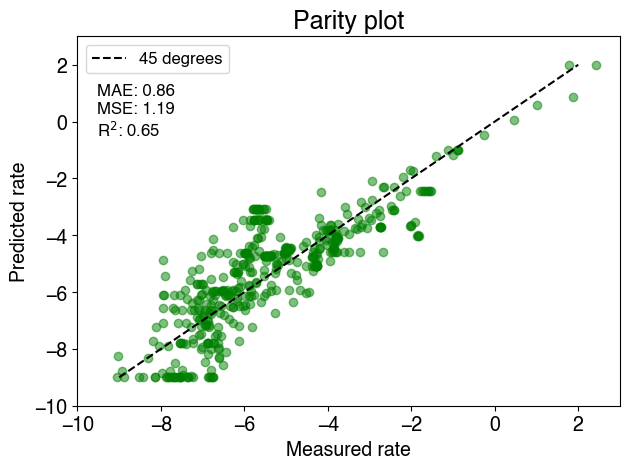

<Figure size 640x480 with 0 Axes>

In [8]:
# y_measured and y_predicted are the two lists of data

# Create the parity plot
plt.scatter(y_measured, y_predicted, color='green', alpha=0.5)

# Calculate evaluation metrics
mae = mean_absolute_error(y_measured, y_predicted)
mse = mean_squared_error(y_measured, y_predicted)
r2 = r2_score(y_measured, y_predicted)

# Add line of best fit:

# Calculate the slope and intercept of the line of best fit
slope, intercept = np.polyfit(y_measured, y_predicted, 1)

# Plot the line of best fit
#plt.plot(y_measured, slope*np.array(y_measured) + intercept, 'r-', label='Line of best fit')

# Add 45 degree line
x_par = np.linspace(-9, 2, 100)
plt.plot(x_par, x_par,'k--', label = '45 degrees')

#Formatting
plt.title('Parity plot', fontdict={'fontsize': 18})
plt.legend(prop={"size":12})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-10,3])
plt.ylim([-10,3])
plt.xlabel("Measured rate",fontdict={'fontsize': 14})
plt.ylabel("Predicted rate",fontdict={'fontsize': 14})

# Display the evaluation metrics on the plot
plt.text(min(y_measured)-0.5, max(y_predicted)-2.5, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nR$^2$: {r2:.2f}', fontsize=12)

plt.tight_layout()

#plt.savefig('figures/parity_plot.png', dpi=600)

plt.figure()

# Figure 4 & 5: molecule 61

In [14]:
from PDB_predictions import KnownBoronicAcid
import matplotlib.pyplot as plt

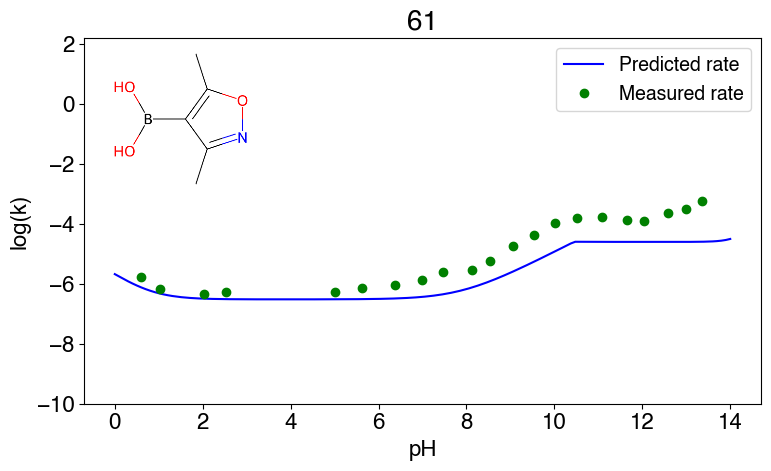

In [15]:
# First we need to initialise a molecule
mol_61 = KnownBoronicAcid(61)

mol_61.plot_result()

In [16]:
#Info
k1 = mol_61.k1
k2 = mol_61.k2
k3 = mol_61.k3
k4 = mol_61.k4
pKa = mol_61.pKa
pKaH = mol_61.pKaH

In [17]:
def k1_rate(pH):
    rate = k1 - 1*pH
    return rate

def k2_rate(pH):  
    if 0 <= pH and pH < pKa:
        b = k2 - 0.75*pKa
        #rate = 10**(0.75*pH+b)
        rate = 0.75*pH+b
    elif pKa <= pH and pH <= 14:
        #rate = 10**(k2)
        rate = k2
    return rate

def k3_rate(pH):
    # y=ax+b => b = y-ax
    b = k3 - 2*14
    rate = 2*pH + b
    return rate

def k4_rate(pH):
    if 0 <= pH and pH < pKaH:
        #y = ax+b => b = y - ax => b = k_max - 0.5*pKaH
        b = k4 - 0.75*pKaH
        rate = 0.75*pH+b
    elif pKaH <= pH and pH <= pKa:
        rate = k4
    elif pKa < pH and pH <= 14:
        b = k4 + 0.75*pKa
        rate = -0.75*pH+b
    return rate

In [18]:
# Measurements
mol_61_pH = [0.59,1.03,2.04,2.54,5,5.63,6.38,6.99,7.47,8.12,8.53,9.06,9.54,10.01,10.52,11.09,11.66,12.04,12.59,13,13.36]
mol_61_measurements = [-5.77,-6.18,-6.35,-6.28,-6.27,-6.14,-6.03,-5.86,-5.6,-5.53,-5.24,-4.75,-4.35,-3.95,-3.81,-3.77,-3.85,-3.9,-3.62,-3.5,-3.22]

In [19]:
len(mol_61_pH) == len(mol_61_measurements)

True

In [27]:
def plot_mol_61(count):
    plt.clf()
    x = []
    y_k1 = []
    y_k2 = []
    y_k3 = []
    y_k4 = []
    obs = []
    i = np.linspace(0, 14, 140)
    for pH in i:
        x += [pH]
        a = k1_rate(pH)
        y_k1 += [a]
        b = k2_rate(pH)
        y_k2 += [b]
        c = k3_rate(pH)
        y_k3 += [c]
        d = k4_rate(pH)
        y_k4 += [d]
        obs += [np.log10(10**a+10**b+10**c+10**d)]

    plt.plot(x, y_k1,'y-', label = '$k_1$')
    plt.plot(x, y_k2,'r-', label = '$k_2$')
    plt.plot(x, y_k3,'c-', label = '$k_3$')
    plt.plot(x, y_k4,'m-', label = '$k_4$')

    if count != 4:
        plt.title('(3,5-dimethyl-1,2-oxazol-4-yl)boronic acid', fontdict={'fontsize': 16})
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylim([-10,2])
        plt.xlabel("pH",fontdict={'fontsize': 14})
        plt.ylabel("log($\it{k}$)",fontdict={'fontsize': 14})

    elif count == 4:
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.ylim([-10,2])
        plt.xlabel("pH",fontdict={'fontsize': 18})
        plt.ylabel("log($\it{k}$)",fontdict={'fontsize': 18})

    plt.tight_layout()
    
    if count == 1:
        plt.legend(prop={"size":12}, loc='upper left') 
        plt.savefig('figures/mol_61_rate_deconstruction_1.png', dpi=600) # No predicted rate
    
    elif count == 2:
        plt.plot(x, obs,'b-', label = 'Predicted rate')
        plt.legend(prop={"size":12}, loc='upper left')
        plt.savefig('figures/mol_61_rate_deconstruction_2.png', dpi=600) # No measurements
    
    elif count == 3:
        plt.plot(x, obs,'b-', label = 'Predicted rate')
        plt.plot(mol_61_pH, mol_61_measurements,'go', label = 'Measurements')
        plt.legend(prop={"size":12}, loc='upper left')
        plt.savefig('figures/mol_61_rate_deconstruction_3.png', dpi=600) # Full figure
    elif count == 4: # Used for abstract/ToC figure
        plt.plot(x, obs,'b-', label = 'Predicted rate')
        plt.plot(mol_61_pH, mol_61_measurements,'go', label = 'Measurements')
        plt.legend(prop={"size":14}, loc='upper left')
        plt.savefig('figures/mol_61_rate_deconstruction_4.png', dpi=600) # Full figure, but bigger text and no title
        




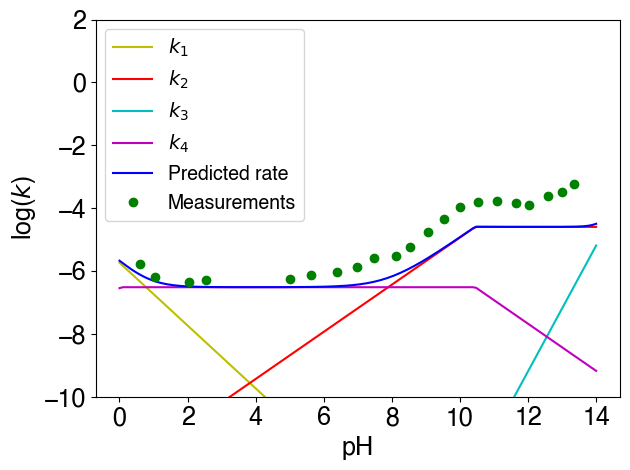

In [33]:
for i in range(1,5):
    plot_mol_61(i)